In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob
from matplotlib.ticker import MultipleLocator
import subprocess
from scipy.optimize import curve_fit

In [2]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))


In [3]:
EE2p = np.array([])
E1 = np.array([])
E2 = np.array([])
Q2p = np.array([])
theta = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E", "E1", "E2", "Q2p", "Theta"],
                            cut="Q2p>0"):
    EE2p=np.append(EE2p, ak.flatten(batch.E))
    E1=np.append(E1, batch.E1)
    E2=np.append(E2, batch.E2)
    Q2p=np.append(Q2p, batch.Q2p)
    theta=np.append(theta, batch.Theta)


In [4]:
len(E1), len(Q2p), len(theta)

(3281, 3281, 3281)

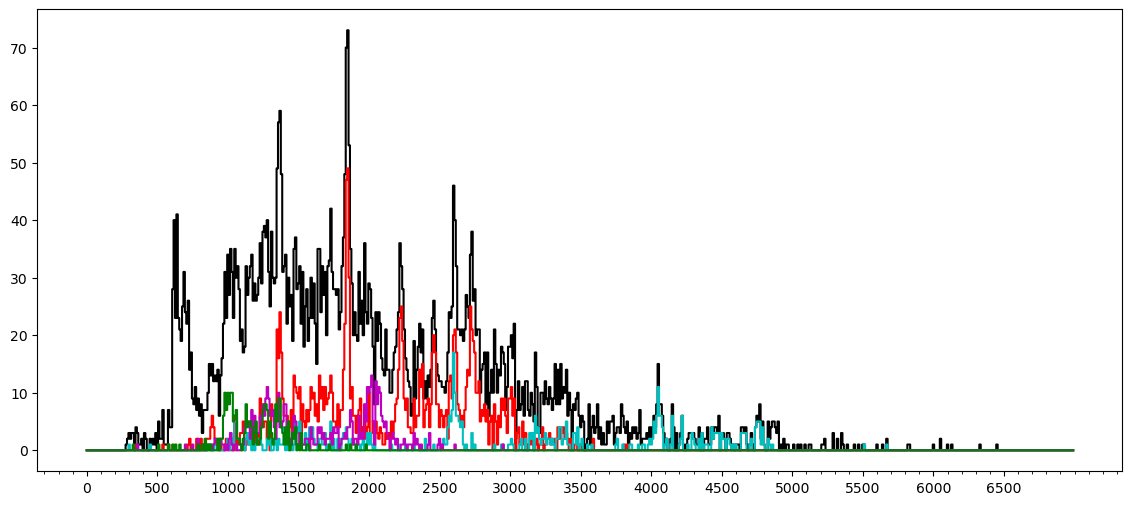

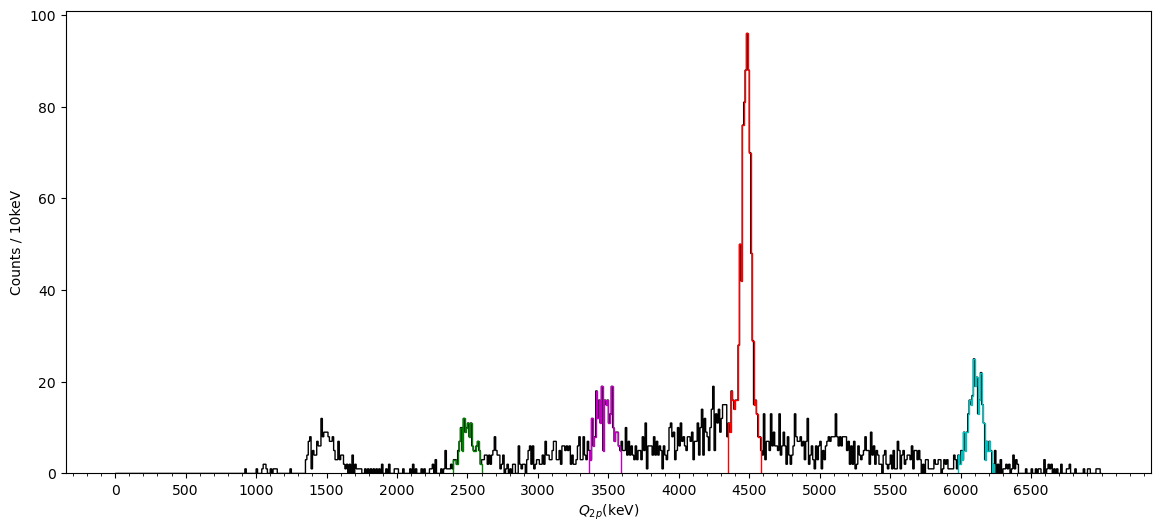

In [7]:
bins = np.arange(0,7000+10,10)

plt.figure(figsize=(14,6))
#plt.hist(EE2p, bins=bins, histtype='step', color='k')
h1, _ = np.histogram(np.array(E1), bins=bins)
h2, _ = np.histogram(np.array(E2), bins=bins)
plt.step(bins[:-1], h1+h2, where='mid', color='k')


lims = [(4350,4580), (6000,6230), (3360,3590), (2400,2600)]#(1350,1600), (2400,2600)]
cols = ['r', 'c', 'm', 'g']#, 'b']
#"""
for l,c in zip(lims,cols):
    mask = (Q2p >= l[0]) & (Q2p <= l[1])
    h1, _ = np.histogram(np.array(E1)[mask], bins=bins)
    h2, _ = np.histogram(np.array(E2)[mask], bins=bins)
    plt.step(bins[:-1], h1+h2, where='mid', color=c)
#"""

plt.xticks(np.arange(0,7000, 500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.show()

plt.figure(figsize=(14,6))
plt.hist(Q2p, bins=np.arange(0,7000+10,10), histtype='step', color='k')

plt.hist(Q2p, bins=np.arange(4350,4580+10,10), histtype='step', color='r')
plt.hist(Q2p, bins=np.arange(5980,6240+10,10), histtype='step', color='c')
#plt.hist(Q2p, bins=np.arange(1350,1600+10,10), histtype='step', color='m')
plt.hist(Q2p, bins=np.arange(2400,2600+10,10), histtype='step', color='g')
plt.hist(Q2p, bins=np.arange(3360,3590+10,10), histtype='step', color='m')
plt.xticks(np.arange(0,7000, 500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.xlabel(r"$Q_{2p}$(keV)")
plt.ylabel("Counts / 10keV")
plt.show()


#plt.figure(figsize=(8,6))
#plt.scatter(E1, Q2p, color='k', s=0.2, marker='o')
#plt.scatter(E2, Q2p, color='k',s=0.2, marker='o')
#plt.ylim(1000,8000)
#plt.show()

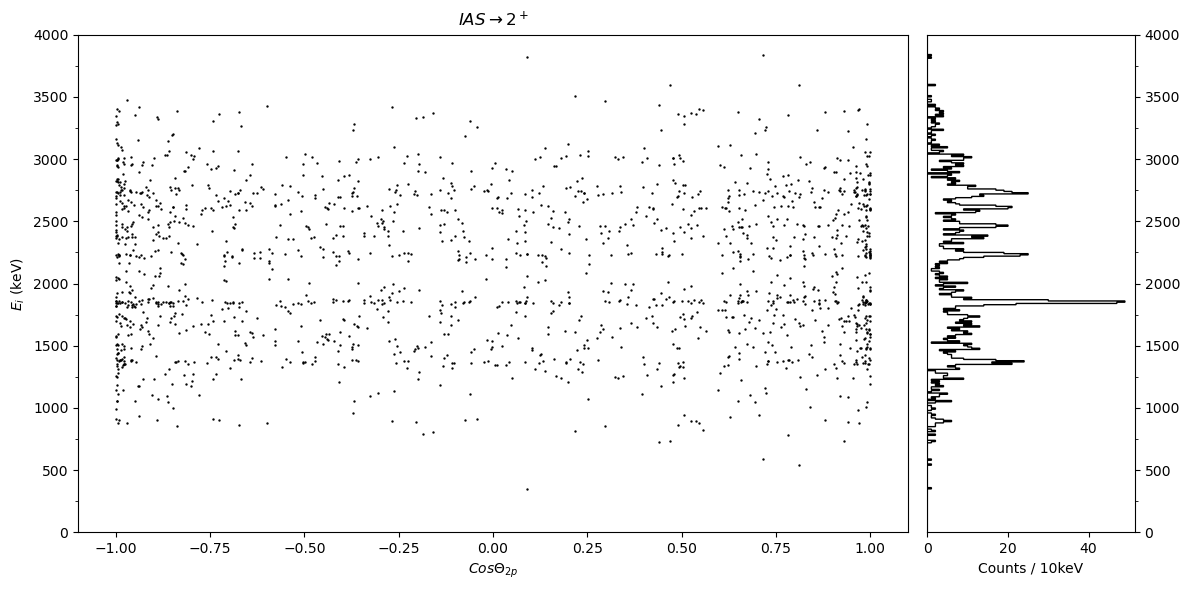

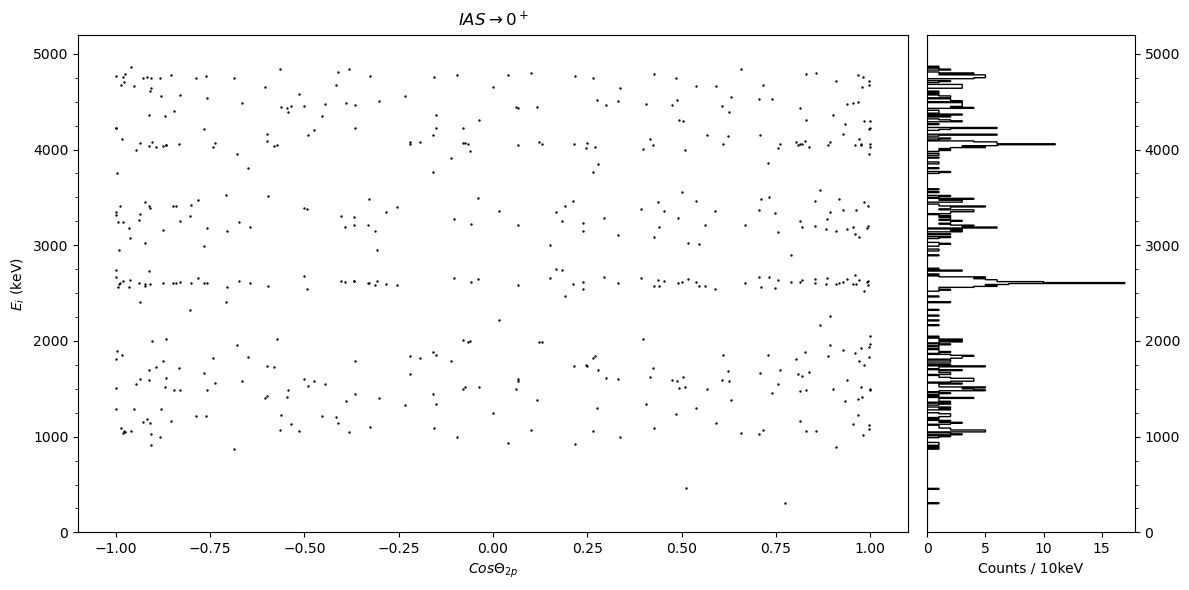

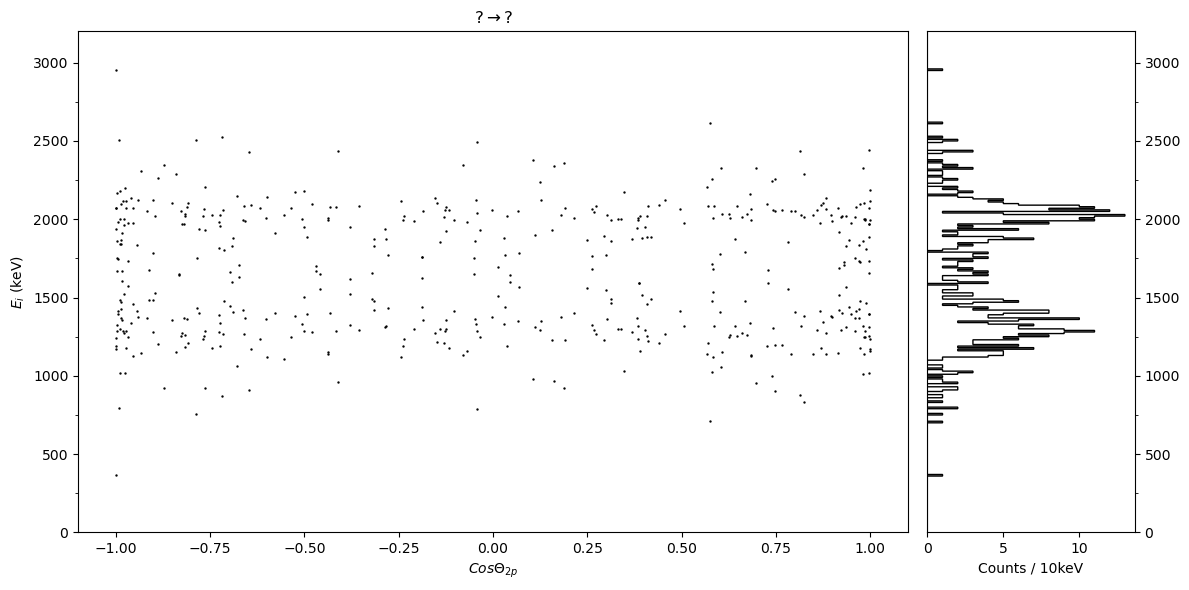

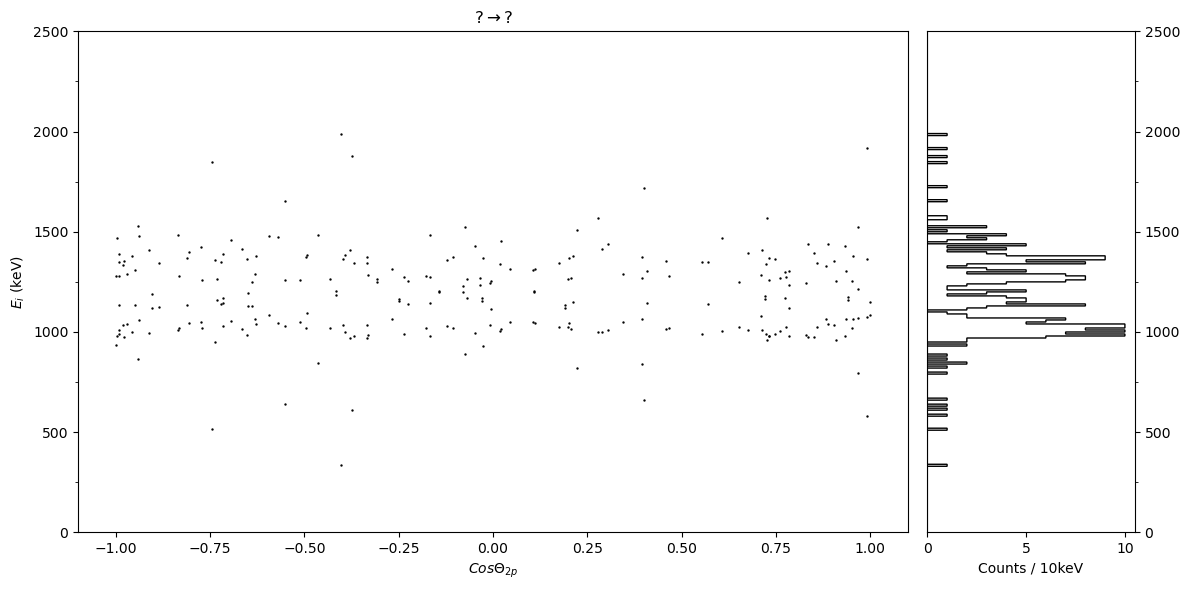

In [7]:
ms = [4000, 5200, 3200, 2500]
lims = [(4350,4580), (6000,6230), (3360,3590), (2400,2600)]
ranges1 = [(1330,1400), (1810,1880), (2210,2260), (2440,2490), (2580,2630), (2690,2760)]
ranges2= [(2530,2670), (4020,4100)]
ranges3 = [(1960,2050), (2050,2140)]
ranges4 = [(950,1050)]


trans = [r"$IAS\rightarrow{2}^+$",r"$IAS\rightarrow{0}^+$",r"$?\rightarrow?$", r"$?\rightarrow?$"]
for l, m,t in zip(lims, ms,trans):
    mask = (Q2p >= l[0]) & (Q2p <= l[1])
    
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True, 
        gridspec_kw={'width_ratios':[4,1]}
    )
    
    # Left: scatter plot
    ax1.scatter(np.cos(theta[mask]), E1[mask], color='k', s=0.5)
    ax1.scatter(np.cos(theta[mask]), E2[mask], color='k', s=0.5)
    ax1.set_xlabel(r"$Cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(f"{t}")
    ax1.set_yticks(np.arange(0,m,250), minor=True)
    ax1.set_ylim(500, m)
    
    # Right: horizontal histogram with 'step' style
    h1, _ = np.histogram(E1[mask], bins=bins)
    h2, _ = np.histogram(E2[mask], bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step', orientation='horizontal', color='k')
    
    #bins2 = np.arange(950,1050+10,10)
    #h3, _ = np.histogram(E1[mask], bins=bins2)
    #h4, _ = np.histogram(E2[mask], bins=bins2)
    #ax2.hist(bins2[:-1], bins=bins2, weights=h3+h4, histtype='step', orientation='horizontal', color='r')

    ax2.set_xlabel('Counts / 10keV')
    ax2.yaxis.set_ticks_position('right')  # ticks on right side
    ax2.set_yticks(np.arange(0,m, 250), minor=True)
    
    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()


In [8]:
mp  = 1007825.031898
mNa = 20997654.459
mNe = 19992440.17525
S1p = 5504.1000
S2p = 7935.9963
QB  = 17600
def y1(x, E1):
    return E1 + 0*x
def y2(x, E1, E2): # E1 may be fixed
    M = mp/mNa
    return E2 - 2*M*np.sqrt(E1*E2)*x + E1*M**2

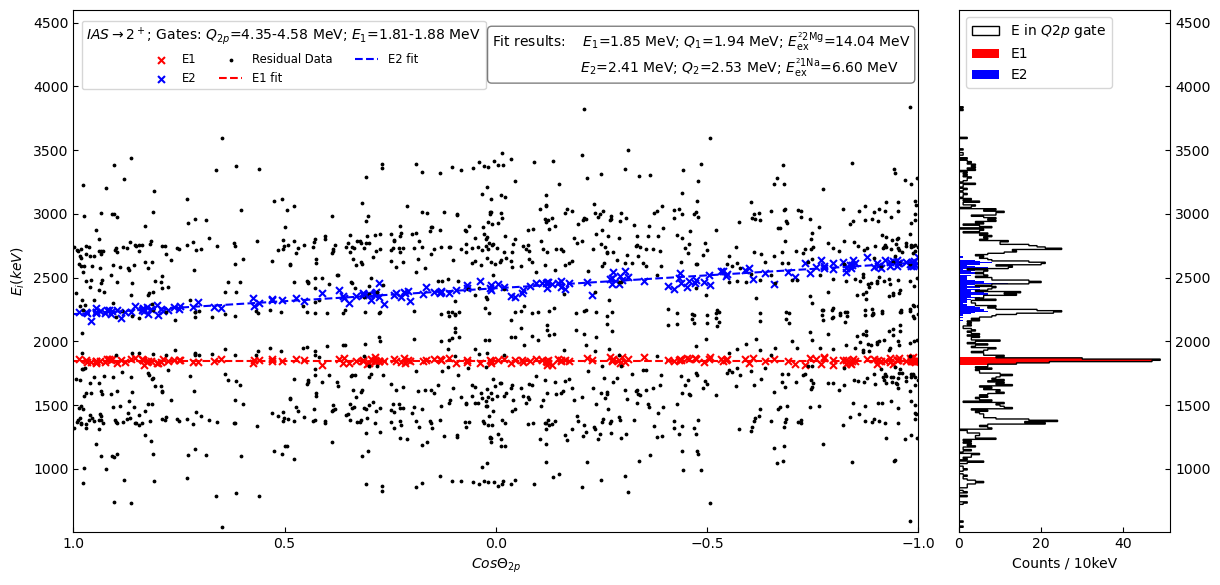

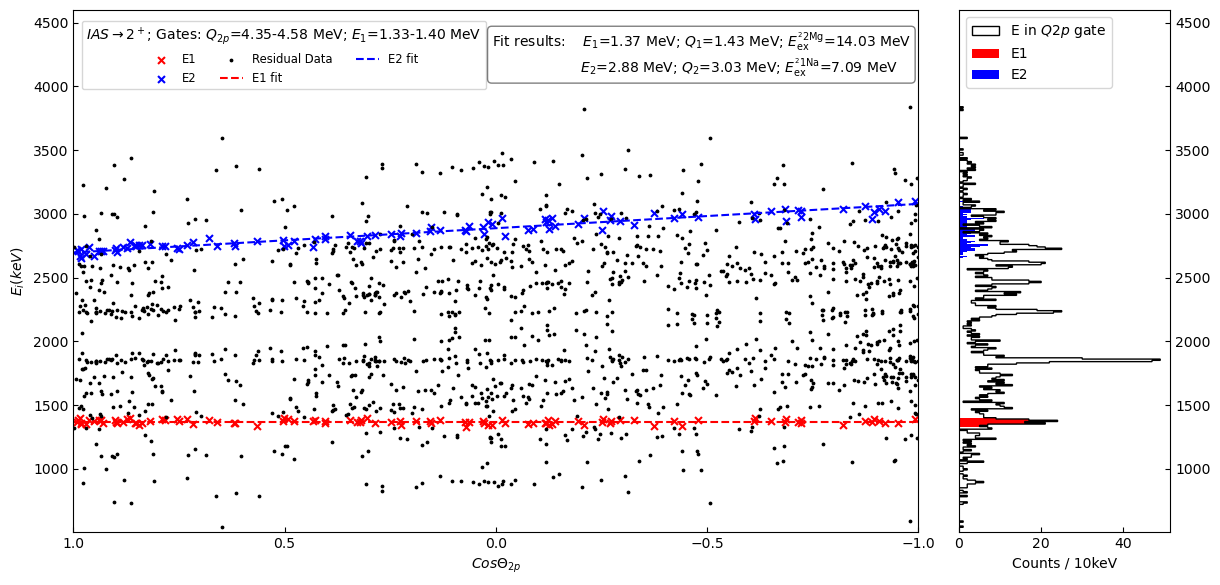

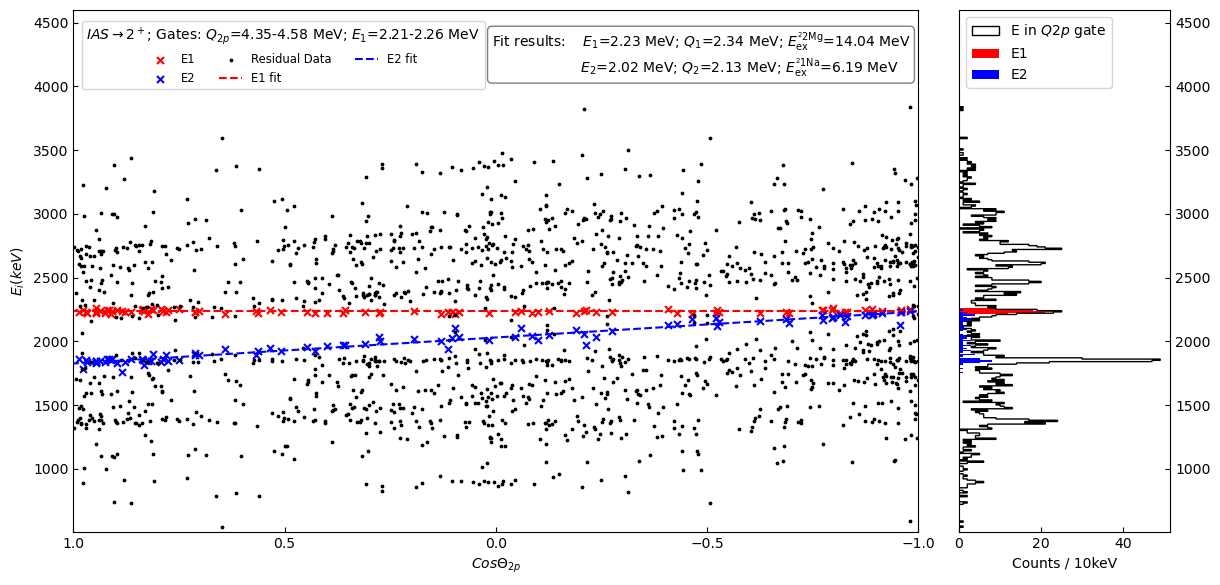

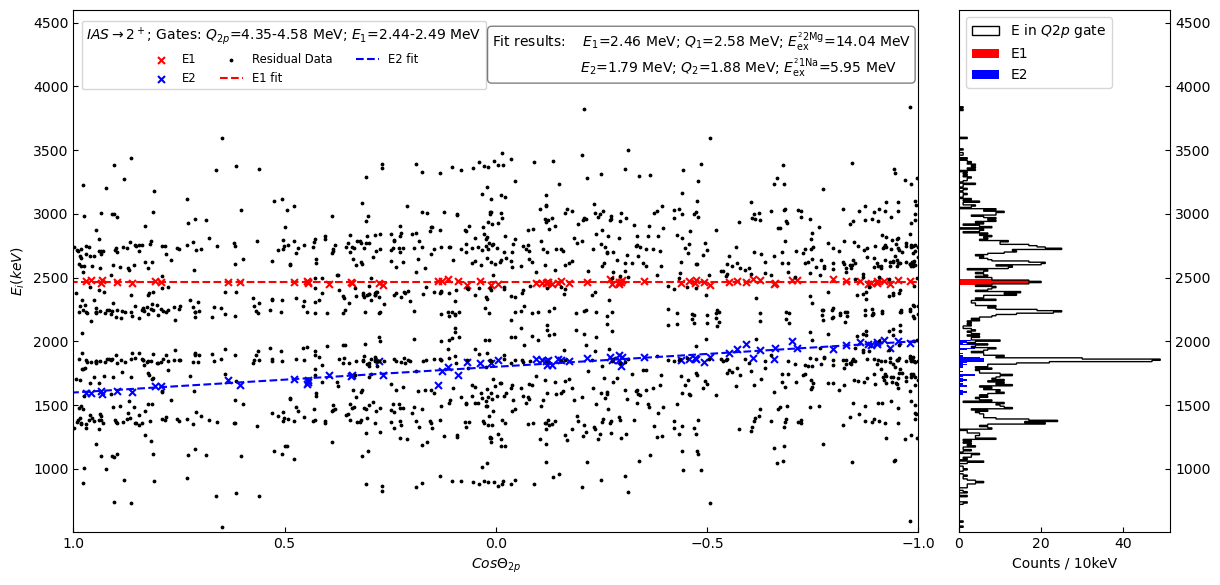

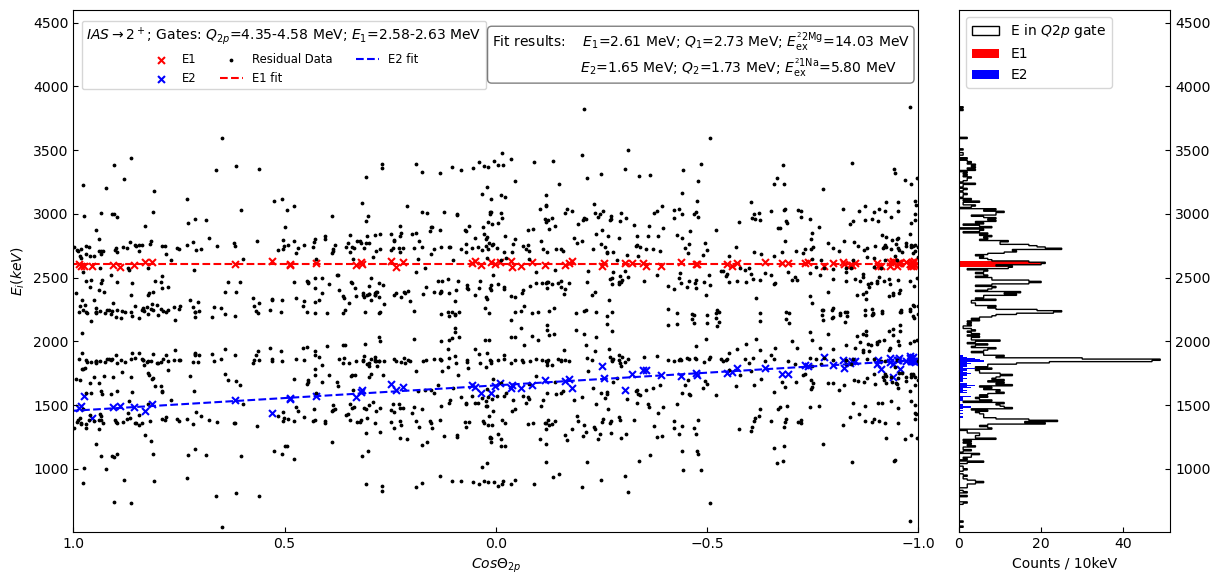

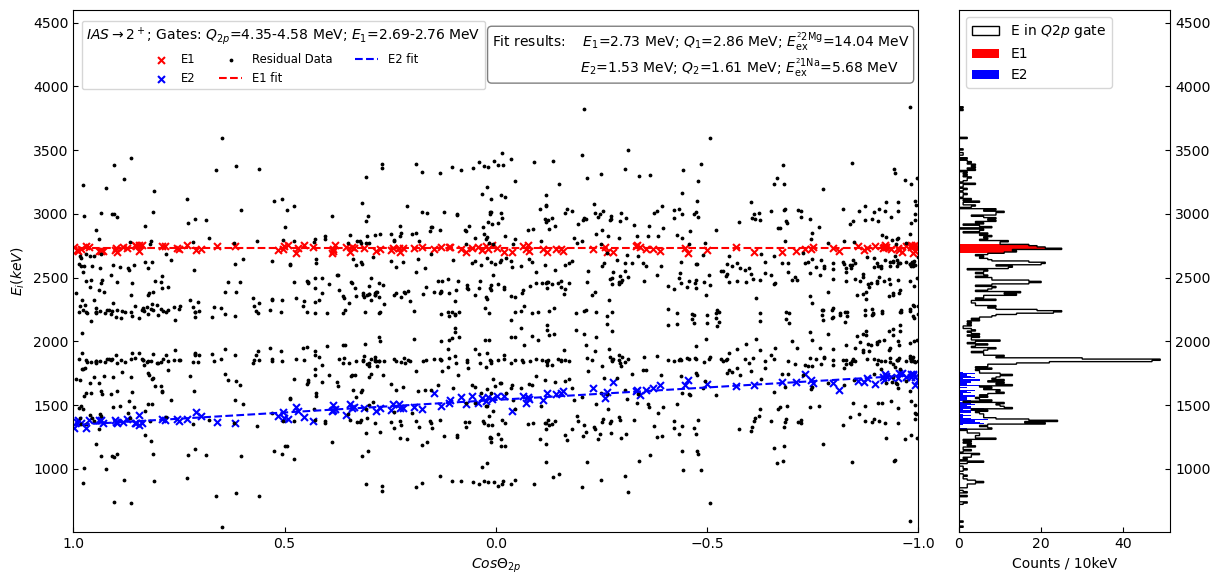

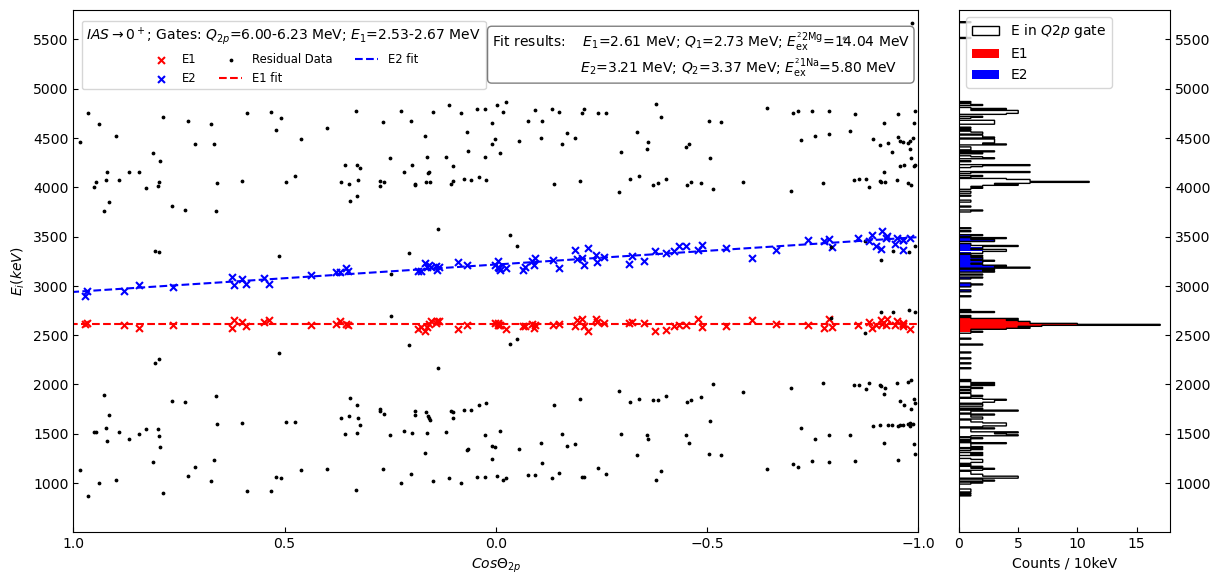

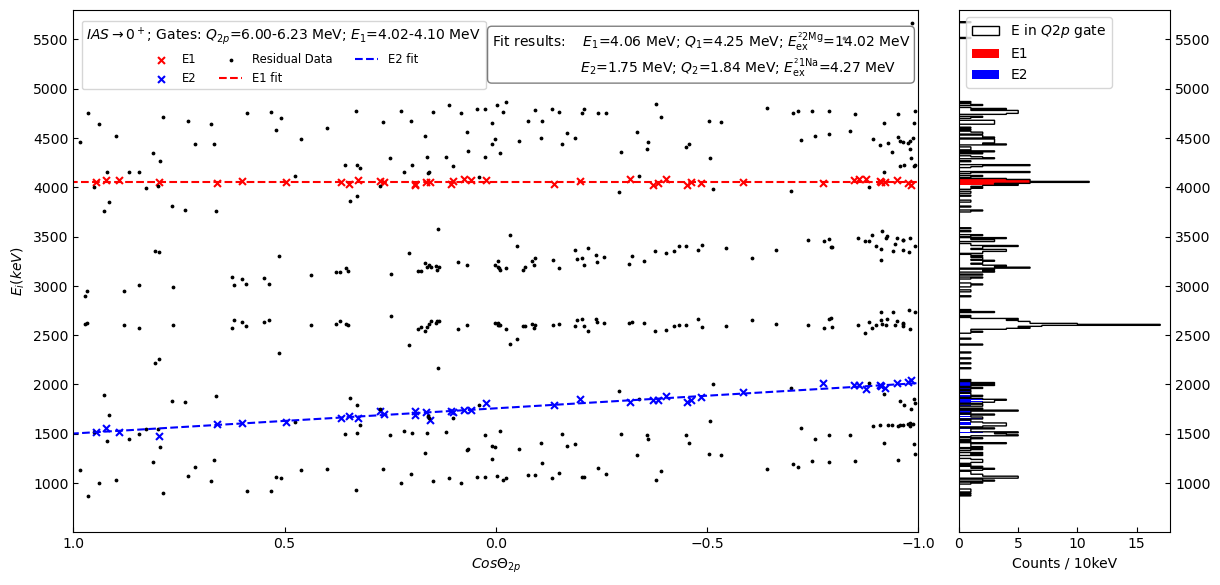

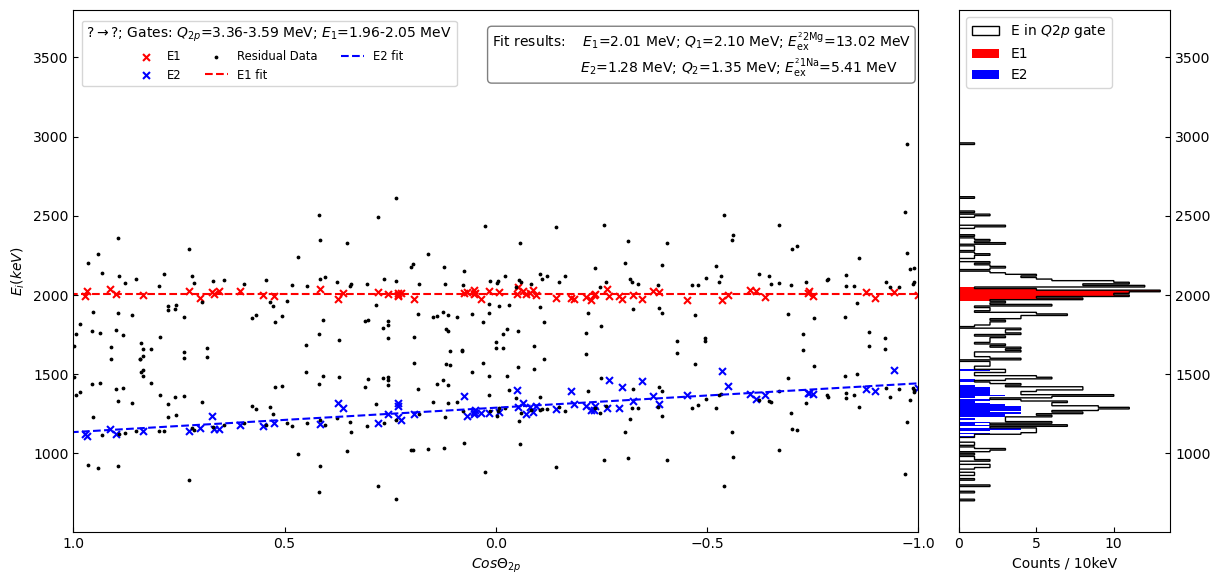

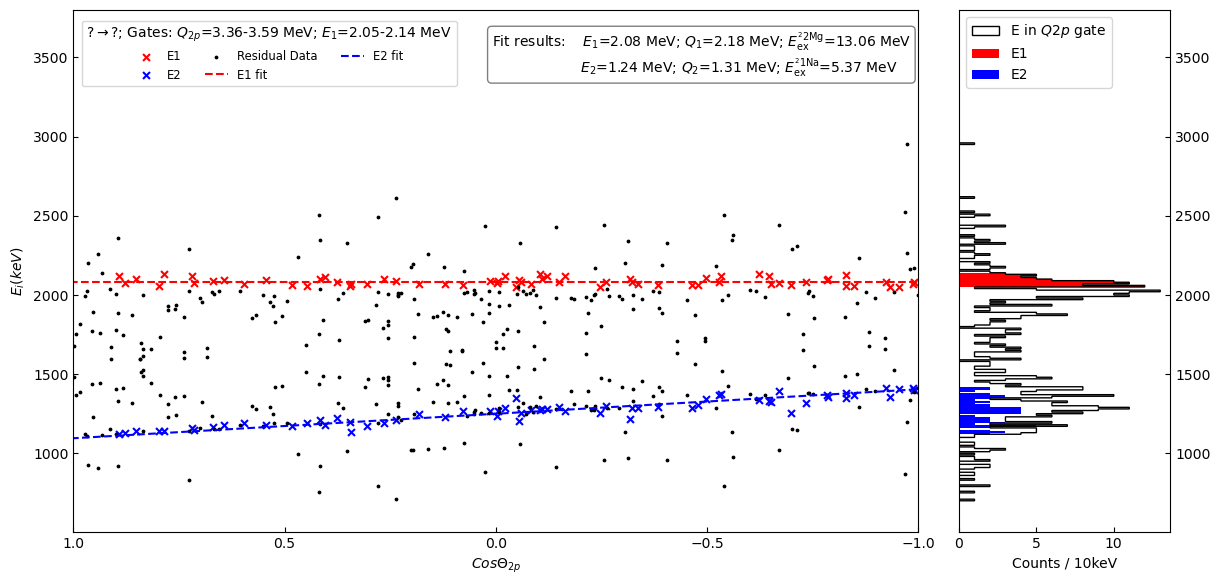

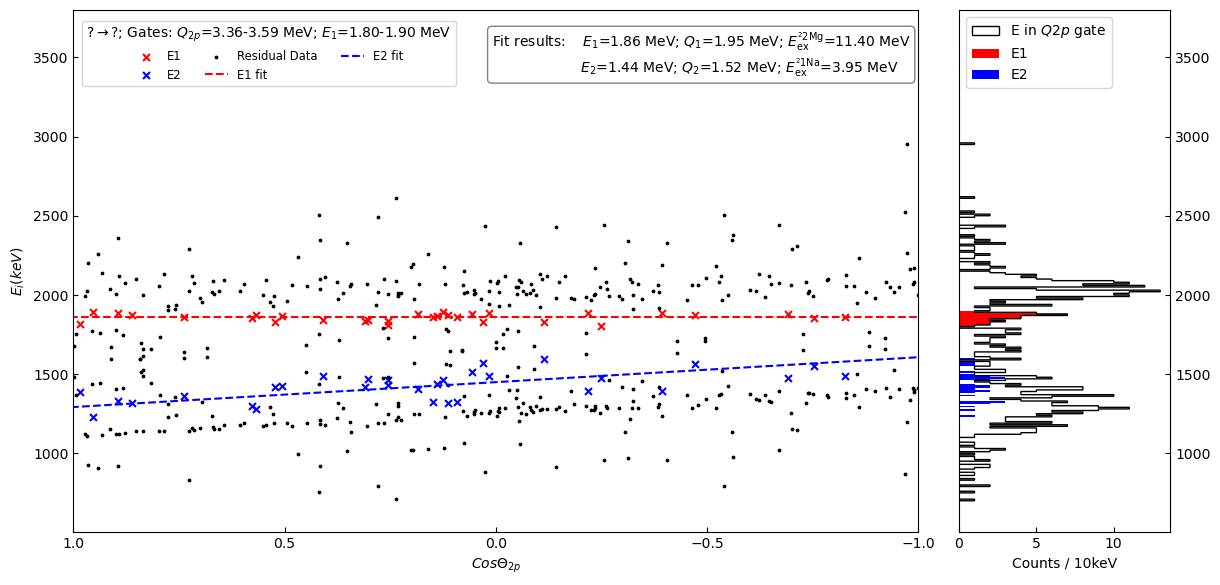

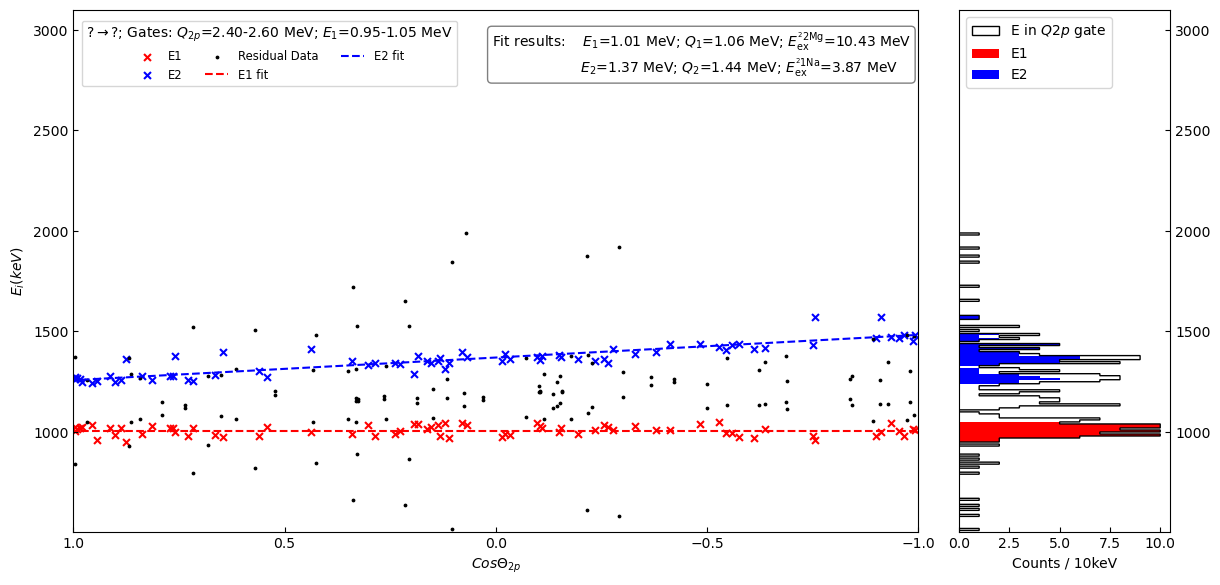

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
Theta = theta
E = EE2p
# Constants
mp  = 1007825.031898
mNa = 20997654.459
mNe = 19992440.17525
S1p = 5504.1000
S2p = 7935.9963
QB  = 17600

def y1(x, E1):
    return E1 + 0*x

def y2(x, E1, E2):  # E1 may be fixed
    M = mp/mNa
    return E2 - 2*M*np.sqrt(E1*E2)*x + E1*M**2
trans = [r"$IAS\rightarrow{2}^+$",r"$IAS\rightarrow{0}^+$",r"$?\rightarrow?$", r"$?\rightarrow?$"]
transition = [[1634,1634,1634,1634,1634,1634], [0,0], [1634,1634,0], [0]]
ms = [4600, 5800, 3800, 3100]
lims = [(4350,4580), (6000,6230), (3360,3590), (2400,2600)]
ranges1 = [(1810,1880), (1330,1400), (2210,2260), (2440,2490), (2580,2630), (2690,2760)]
ranges2= [(2530,2670), (4020,4100)]
ranges3 = [(1960,2050), (2050,2140), (1800,1900)]#1960,2140)]#
ranges4 = [(950,1050)]#, (1100,1250)]
ranges = [ranges1, ranges2, ranges3, ranges4]

X = np.linspace(-1.1, 1.1, 100)

txa = 0.15
tya = 0.84
txb = txa
tyb = 0.3

for i in range(len(lims)):
    Q2p_low = lims[i][0]
    Q2p_upp = lims[i][1]
    Q2p_mean = Q2p_low + (Q2p_upp - Q2p_low)/2
    mask = (Q2p >= Q2p_low) & (Q2p <= Q2p_upp)
    e1s = E1[mask]
    e2s = E2[mask]
    for j in range(len(ranges[i])):
        # Arrays for selected and residual events
        e1 = e2 = CosTheta = np.array([])
        e1R = e2R = CosThetaR = np.array([])

        E1_low  = ranges[i][j][0]
        E1_upp  = ranges[i][j][1]
        E1_mean = E1_low + (E1_upp - E1_low)/2
        Q1_mean = E1_mean*(mNa + mp)/mNa
        used_indices = np.array([])

        for k in range(len(Q2p)):
            if k in used_indices:
                    continue
            if Q2p_low <= Q2p[k] <= Q2p_upp:
                # Determine which proton is E1 and which is E2
                if Q1_mean > Q2p_mean/2:
                    E1tmp = max(E[2*k], E[2*k+1])
                    E2tmp = min(E[2*k], E[2*k+1])
                else:
                    E1tmp = min(E[2*k], E[2*k+1])
                    E2tmp = max(E[2*k], E[2*k+1])

                # Assign to selected or residual arrays
                if E1_low <= E1tmp <= E1_upp:
                    e1 = np.append(e1, E1tmp)
                    e2 = np.append(e2, E2tmp)
                    CosTheta = np.append(CosTheta, np.cos(np.deg2rad(Theta[k])))
                    used_indices = np.append(used_indices, k)

                else:
                    e1R = np.append(e1R, E1tmp)
                    e2R = np.append(e2R, E2tmp)
                    CosThetaR = np.append(CosThetaR, np.cos(np.deg2rad(Theta[k])))

        # Fit
        if len(e1) > 0:
            p1, c1 = curve_fit(y1, CosTheta, e1, p0=E1_mean)
            p2, c2 = curve_fit(y2, CosTheta, e2, p0=[p1[0], Q2p_mean-Q1_mean],
                               bounds=([p1[0],0],[p1[0]+1e-12,Q2p_mean]))

        # Plot
        fig, (ax1, ax2) = plt.subplots(
            1, 2, figsize=(12,6), sharey=True, 
            gridspec_kw={'width_ratios':[4,1]}
        )
        #fig.subplots_adjust(wspace=0.05) 
        # Left scatter plot
        ax1.scatter(CosTheta, e1, s=25, marker='x', color='r', label='E1')
        ax1.scatter(CosTheta, e2, s=25, marker='x', color='b', label="E2")#facecolors='w', edgecolors='b', label='E2')
        ax1.scatter(CosThetaR, e1R, s=3, color='k', label='Residual Data')
        ax1.scatter(CosThetaR, e2R, s=3, color='k')

        E1_est = p1[0]
        Q1_est = E1_est*(mNa + mp)/mNa
        E2_est = p2[1]
        Q2_est = E2_est*(mNe + mp)/mNe
        E2_min = y2(1, E1_est, E2_est)
        E2_max = y2(-1, E1_est, E2_est)
        
        ax1.set_xlim(1, -1)
        ax1.set_ylabel(f"$E_i (keV)$")
        ax1.plot(X, y1(X, *p1), '--', color='r', label="E1 fit")#, label=rf"Fit $E_1$={p1[0]/1e3:.2f} MeV; $Q_1$={Q1_est/1e3:.2f} MeV; $E_{{ex}}^{{22\mathrm{{Mg}}}}$={(Q1_est+Q2_est + 7.936e3 + transition[i])/1e3:.2f} MeV")
        ax1.plot(X, y2(X, *p2), '--', color='b', label="E2 fit")#, label=rf"Fit $E_2$={p2[1]/1e3:.2f} MeV; $Q_2$={Q2_est/1e3:.2f} MeV; $E_{{ex}}^{{21\mathrm{{Na}}}}$={(Q2_est + 2.432e3 + transition[i])/1e3:.2f} MeV")
        ax1.legend(title=rf"{trans[i]}; Gates: $Q_{{2p}}$={Q2p_low/1e3:.2f}-{Q2p_upp/1e3:.2f} MeV; $E_1$={E1_low/1e3:.2f}-{E1_upp/1e3:.2f} MeV", fontsize='small', loc='upper left', ncol=3, bbox_to_anchor=(0.003, 0.99))
        
        # Right histogram
        bins = np.arange(0,7000+10,10)#min(np.min(e1), np.min(e2), np.min(e1R), np.min(e2R)),
                         #max(np.max(e1), np.max(e2), np.max(e1R), np.max(e2R))+25, 25)
        h1, _ = np.histogram(e1s, bins=bins)
        h2, _ = np.histogram(e2s, bins=bins)
        hR, _ = np.histogram(np.concatenate([e1R,e2R]), bins=bins)
        ax2.hist(bins[:-1], bins=bins, weights=h1+h2, orientation='horizontal', color='k', histtype='step', label=r"E in $Q{2p}$ gate")
        ax2.hist(e1, bins=bins, orientation='horizontal', color='r', label="E1")#, histtype='step')
        ax2.hist(e2, bins=bins, orientation='horizontal', color='b', label="E2")#, histtype='step')
        #ax2.hist(bins[:-1], bins=bins, weights=hR, orientation='horizontal', color='k', histtype='step')
        ax2.set_xlabel('Counts / 10keV')
        ax2.yaxis.tick_right()

        ax2.legend(loc='upper left')
        ax2.yaxis.tick_right()
        ax1.set_xlabel(r"$Cos\Theta_{2p}$")
        
        fig.text(0.418, 0.87, 
         rf"Fit results:    $E_1$={E1_est/1e3:.2f} MeV; $Q_1$={Q1_est/1e3:.2f} MeV; $E_{{\mathrm{{ex}}}}^{{^{22}\mathrm{{Mg}}}}$={(S2p + transition[i][j] + Q2_est + Q1_est)/1e3:.2f} MeV" 
         + "\n" +
         rf"                    $E_2$={E2_est/1e3:.2f} MeV; $Q_2$={Q2_est/1e3:.2f} MeV; $E_{{\mathrm{{ex}}}}^{{^{21}\mathrm{{Na}}}}$={(S2p + transition[i][j] - S1p + Q2_est)/1e3:.2f} MeV",
         bbox=dict(boxstyle="round", ec='k', fc='w', alpha=0.5))


        #fig.text(X2, Y2, "Fit results: $E_{2}\sim%.2f\,..%.2f$ MeV; $Q_{2}\sim%.2f$ MeV; $E_{\mathrm{ex}}^{^{21}\mathrm{Na}}\sim%.2f$ MeV" 
        #             % (E2_min/1e3, E2_max/1e3, Q2_est/1e3, ((S2p + transition[i]) - S1p + Q2_est)/1e3),
        #            bbox=dict(boxstyle="round", ec='k', fc='w',alpha=0.5,), fontsize='x-small')
        
        plt.tight_layout()
        ax1.tick_params(axis='both', direction='in', which='both')
        ax2.tick_params(axis='both', direction='in', which='both') #ax.minorticks_on()
        ax2.tick_params(axis="y", labelleft=False, labelright=True)
        ax1.set_yticks(np.arange(500, ms[i], 500))
        ax1.set_xticks(np.arange(1,-1.1, -0.5))
        ax2.set_ylim(501,ms[i])
        plt.show()


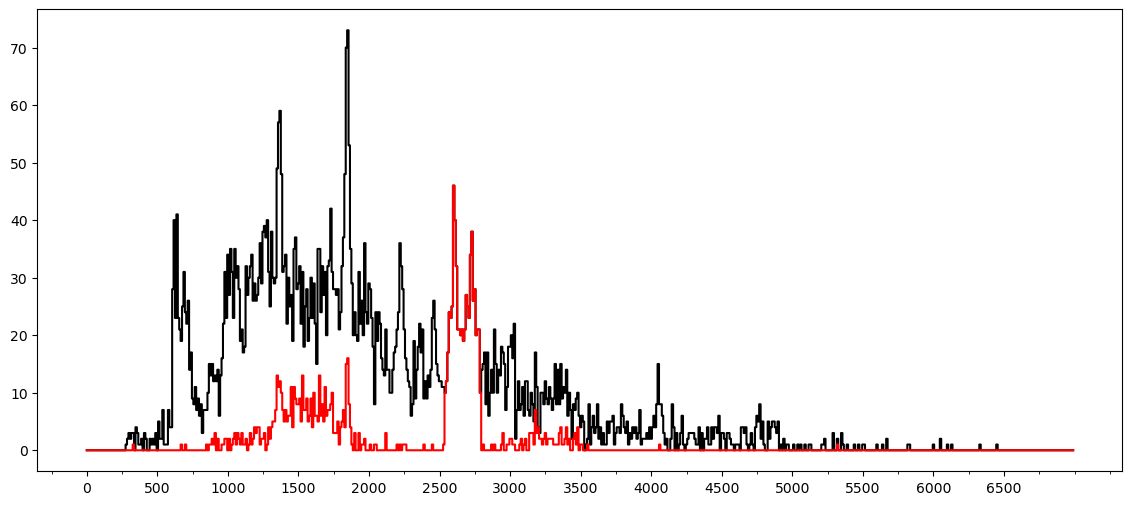

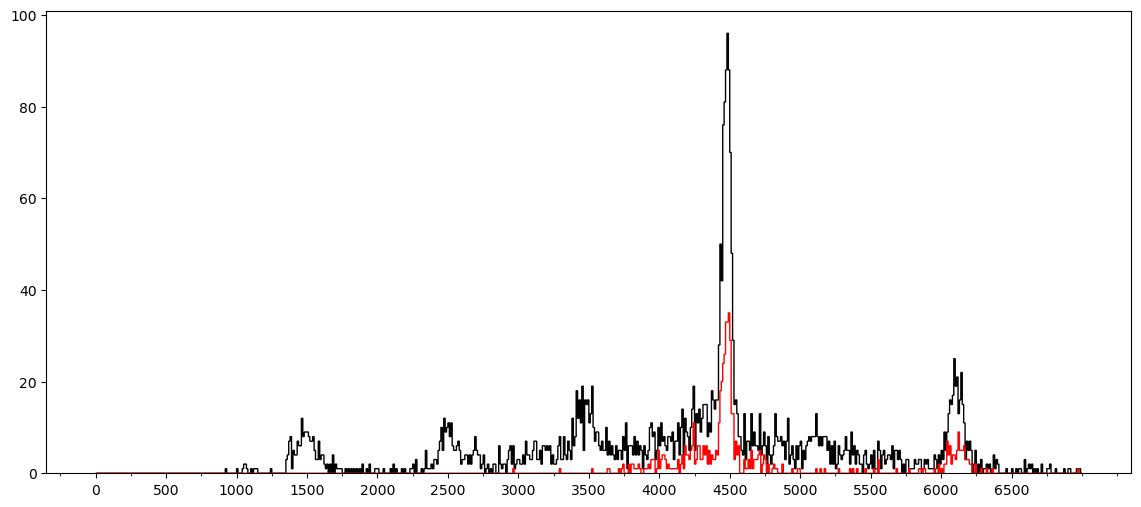

In [ ]:
bins = np.arange(0,7000+10,10)

plt.figure(figsize=(14,6))
#plt.hist(EE2p, bins=bins, histtype='step', color='k')
h1, _ = np.histogram(np.array(E1), bins=bins)
h2, _ = np.histogram(np.array(E2), bins=bins)
plt.step(bins[:-1], h1+h2, where='mid', color='k')

low = 2540
up = 2800
mask = ((E1 >= low) & (E1 <= up)) | ((E2 >= low) & (E2 <= up))

h3, _ = np.histogram(np.array(E1)[mask], bins=bins)#np.arange(low,up+10,10))
h4, _ = np.histogram(np.array(E2)[mask], bins=bins)#np.arange(low,up+10,10))
plt.step(bins[:-1], h3+h4, where='mid', color='r')


lims = [(4350,4580), (6000,6230)]#, (1350,1600), (2400,2600), (3360,3570)]
cols = ['r', 'c']#, 'm', 'g', 'b']
"""
for l,c in zip(lims,cols):
    mask = (Q2p >= l[0]) & (Q2p <= l[1])
    h1, _ = np.histogram(np.array(E1)[mask], bins=bins)
    h2, _ = np.histogram(np.array(E2)[mask], bins=bins)
    plt.step(bins[:-1], h1+h2, where='mid', color=c)
"""

plt.xticks(np.arange(0,7000, 500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(250))
plt.show()

plt.figure(figsize=(14,6))
plt.hist(Q2p, bins=np.arange(0,7000+10,10), histtype='step', color='k')
plt.hist(Q2p[mask], bins=np.arange(0,7000+10,10), histtype='step', color='r')

#plt.hist(Q2p, bins=np.arange(4350,4580+10,10), histtype='step', color='r')
#plt.hist(Q2p, bins=np.arange(6000,6230+10,10), histtype='step', color='c')
#plt.hist(Q2p, bins=np.arange(1350,1600+10,10), histtype='step', color='m')
#plt.hist(Q2p, bins=np.arange(2400,2600+10,10), histtype='step', color='g')
#plt.hist(Q2p, bins=np.arange(3360,3570+10,10), histtype='step', color='b')
plt.xticks(np.arange(0,7000, 500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(250))
plt.show()


#plt.figure(figsize=(8,6))
#plt.scatter(E1, Q2p, color='k', s=0.2, marker='o')
#plt.scatter(E2, Q2p, color='k',s=0.2, marker='o')
#plt.ylim(1000,8000)
#plt.show()

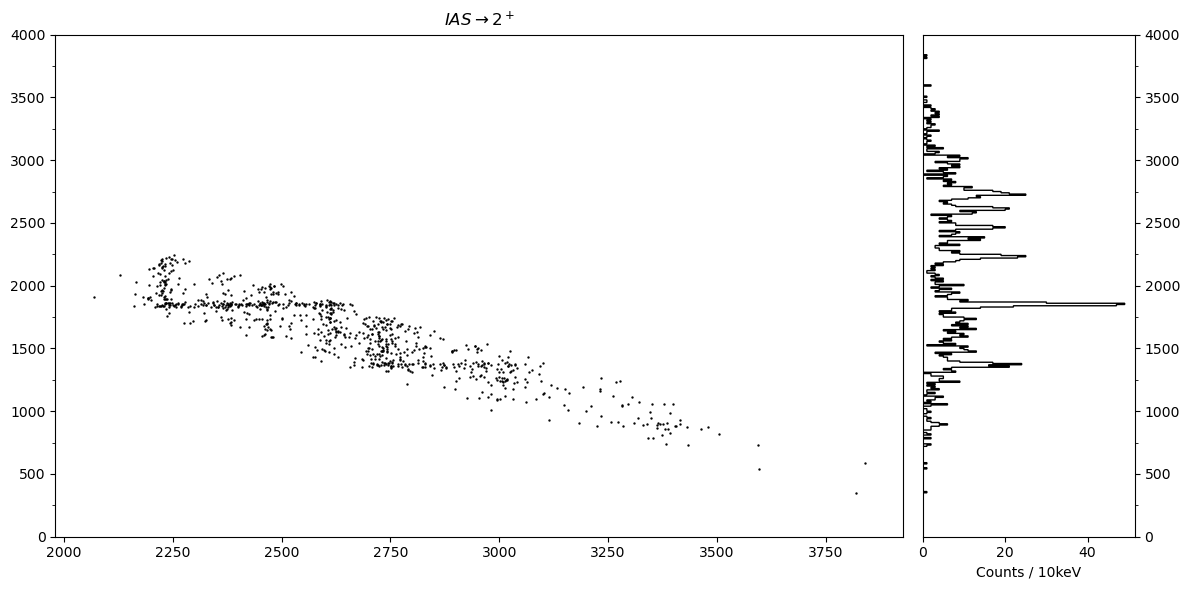

In [19]:
ms = [4000]#, 5200, 3200, 2500]
lims = [(4350,4580)]#, (6000,6230), (3360,3590), (2400,2600)]
ranges1 = [(1330,1400), (1810,1880), (2210,2260), (2440,2490), (2580,2630), (2690,2760)]
ranges2= [(2530,2670), (4020,4100)]
ranges3 = [(1960,2050), (2050,2140)]
ranges4 = [(950,1050)]


trans = [r"$IAS\rightarrow{2}^+$"]#,r"$IAS\rightarrow{0}^+$",r"$?\rightarrow?$", r"$?\rightarrow?$"]
for l, m,t in zip(lims, ms,trans):
    mask = (Q2p >= l[0]) & (Q2p <= l[1])
    Q_mean = (l[0]+l[1])/2
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True, 
        gridspec_kw={'width_ratios':[4,1]}
    )
    
    # Left: scatter plot
    #ax1.scatter(np.cos(theta[mask]), E1[mask], color='k', s=0.5)
    #ax1.scatter(np.cos(theta[mask]), E2[mask], color='k', s=0.5)
    #ax1.set_xlabel(r"$Cos\Theta_{2p}$")
    #ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(f"{t}")
    ax1.set_yticks(np.arange(0,m,250), minor=True)
    ax1.set_ylim(500, m)
    
    # Right: horizontal histogram with 'step' style
    h1, _ = np.histogram(E1[mask], bins=bins)
    h2, _ = np.histogram(E2[mask], bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step', orientation='horizontal', color='k')
    
    ex = [] ## largest vals
    ey = [] ## lowest vals
    for e1,e2 in zip(E1[mask], E2[mask]):
        if e1>e2:
            ex.append(e1)
            ey.append(e2)
        else:
            ex.append(e2)
            ey.append(e1)
    ax1.scatter(ex,ey, color='k', s=0.5)  
    
    #bins2 = np.arange(950,1050+10,10)
    #h3, _ = np.histogram(E1[mask], bins=bins2)
    #h4, _ = np.histogram(E2[mask], bins=bins2)
    #ax2.hist(bins2[:-1], bins=bins2, weights=h3+h4, histtype='step', orientation='horizontal', color='r')

    
    ax2.set_xlabel('Counts / 10keV')
    ax2.yaxis.set_ticks_position('right')  # ticks on right side
    ax2.set_yticks(np.arange(0,m, 250), minor=True)
    
    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()
